# Python: Conditional Average Treatment Effects (CATEs) for IRM models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate conditional average treatment effects with B-splines for one or two-dimensional effects in the [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) model.

In [12]:
import numpy as np
import pandas as pd
import doubleml as dml

from doubleml.datasets import make_heterogeneous_data

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html).

The documentation of the data generating process can be found [here](https://docs.doubleml.org/dev/api/api.html#dataset-generators).

## One-dimensional Example

We start with an one-dimensional effect and create our training data. In this example the true effect depends only the first covariate $X_0$ and takes the following form

$$
\theta_0(X) = \exp(2X_0) + 3\sin(4X_0).
$$

The generated dictionary also contains a callable with key `treatment_effect` to calculate the true treatment effect for new observations.

In [13]:
np.random.seed(42)
data_dict = make_heterogeneous_data(
    n_obs=2000,
    p=10,
    support_size=5,
    n_x=1,
    binary_treatment=True,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
print(data.head())

          y    d       X_0       X_1       X_2       X_3       X_4       X_5  \
0  4.803300  1.0  0.259828  0.886086  0.895690  0.297287  0.229994  0.411304   
1  5.655547  1.0  0.824350  0.396992  0.156317  0.737951  0.360475  0.671271   
2  1.878402  0.0  0.988421  0.977280  0.793818  0.659423  0.577807  0.866102   
3  6.941440  1.0  0.427486  0.330285  0.564232  0.850575  0.201528  0.934433   
4  1.703049  1.0  0.016200  0.818380  0.040139  0.889913  0.991963  0.294067   

        X_6       X_7       X_8       X_9  
0  0.240532  0.672384  0.826065  0.673092  
1  0.270644  0.081230  0.992582  0.156202  
2  0.289440  0.467681  0.619390  0.411190  
3  0.689088  0.823273  0.556191  0.779517  
4  0.210319  0.765363  0.253026  0.865562  


First, define the ``DoubleMLData`` object.

In [14]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

Next, define the learners for the nuisance functions and fit the [IRM Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html). Remark that linear learners would usually be optimal due to the data generating process.

In [15]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.05,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit()

print(dml_irm.summary)

Training IRM Model
       coef   std err           t  P>|t|     2.5 %    97.5 %
d  4.466251  0.041508  107.600481    0.0  4.384897  4.547605


To estimate the CATE, we rely on the best-linear-predictor of the linear score as in [Semenova et al. (2021)](https://doi.org/10.1093/ectj/utaa027) To approximate the target function $\theta_0(x)$ with a linear form, we have to define a data frame of basis functions. Here, we rely on [patsy](https://patsy.readthedocs.io/en/latest/) to construct a suitable basis of [B-splines](https://en.wikipedia.org/wiki/B-spline).

In [16]:
import patsy
design_matrix = patsy.dmatrix("bs(x, df=5, degree=2)", {"x": data["X_0"]})
spline_basis = pd.DataFrame(design_matrix)

To estimate the parameters to calculate the CATE estimate call the ``cate()`` method and supply the dataframe of basis elements.

In [17]:
cate = dml_irm.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err          t          P>|t|    [0.025    0.975]
0  0.666839  0.165197   4.036637   5.627191e-05  0.342863  0.990815
1  2.328422  0.275022   8.466317   4.835465e-17  1.789062  2.867782
2  4.951772  0.176802  28.007405  7.698326e-146  4.605035  5.298508
3  4.766565  0.211757  22.509645  3.623718e-100  4.351278  5.181853
4  3.708023  0.215120  17.237035   3.575184e-62  3.286140  4.129905
5  4.346897  0.231207  18.800924   9.971835e-73  3.893465  4.800329


To obtain the confidence intervals for the CATE, we have to call the ``confint()`` method and a supply a dataframe of basis elements.
This could be the same basis as for fitting the CATE model or a new basis to e.g. evaluate the CATE model on a grid.
Here, we will evaluate the CATE on a grid from 0.1 to 0.9 to plot the final results.
Further, we construct uniform confidence intervals by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [18]:
new_data = {"x": np.linspace(0.1, 0.9, 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)
print(df_cate)

       2.5 %    effect    97.5 %
0   2.058569  2.326686  2.594803
1   2.174741  2.447545  2.720348
2   2.287759  2.566408  2.845057
3   2.398312  2.683277  2.968242
4   2.506963  2.798151  3.089339
..       ...       ...       ...
95  4.376939  4.664438  4.951937
96  4.384978  4.666362  4.947745
97  4.395821  4.670832  4.945844
98  4.408869  4.677850  4.946831
99  4.423377  4.687415  4.951452

[100 rows x 3 columns]


Finally, we can plot our results and compare them with the true effect.

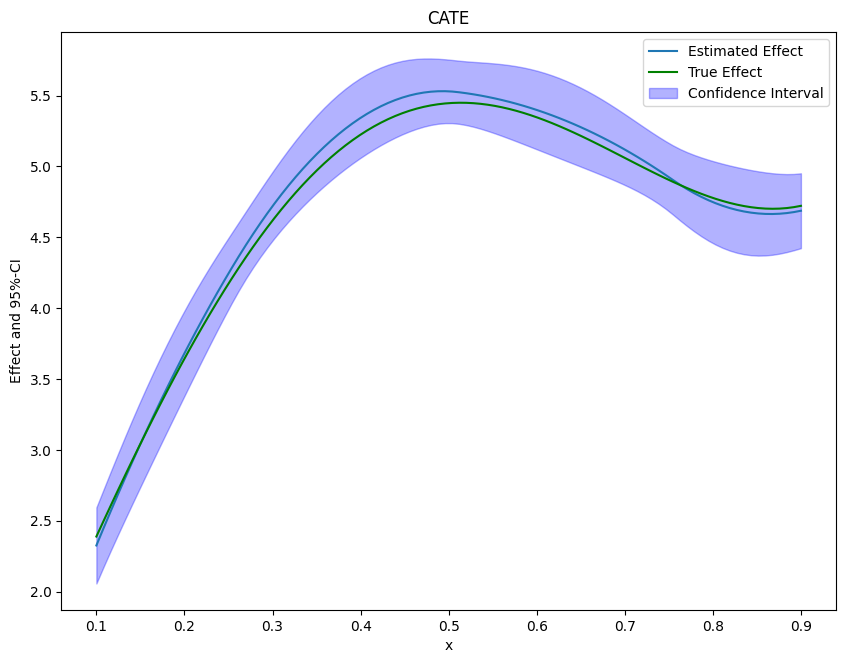

In [19]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['x']
df_cate['true_effect'] = treatment_effect(new_data["x"].reshape(-1, 1))
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['true_effect'], color="green", label='True Effect')
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

If the effect is not one-dimensional, the estimate still corresponds to the projection of the true effect on the basis functions.

## Two-Dimensional Example

It is also possible to estimate multi-dimensional conditional effects. We will use a similar data generating process but now the effect depends on the first two covariates $X_0$ and $X_1$ and takes the following form
$$
\theta_0(X) = \exp(2X_0) + 3\sin(4X_1).
$$

With the argument ``n_x=2`` we can specify set the effect to be two-dimensional.

In [20]:
np.random.seed(42)
data_dict = make_heterogeneous_data(
    n_obs=5000,
    p=10,
    support_size=5,
    n_x=2,
    binary_treatment=True,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
print(data.head())

          y    d       X_0       X_1       X_2       X_3       X_4       X_5  \
0  1.286203  1.0  0.014080  0.006958  0.240127  0.100807  0.260211  0.177043   
1  0.416899  1.0  0.152148  0.912230  0.892796  0.653901  0.672234  0.005339   
2  2.087634  1.0  0.344787  0.893649  0.291517  0.562712  0.099731  0.921956   
3  7.508433  1.0  0.619351  0.232134  0.000943  0.757151  0.985207  0.809913   
4  0.567695  0.0  0.477130  0.447624  0.775191  0.526769  0.316717  0.258158   

        X_6       X_7       X_8       X_9  
0  0.028520  0.909304  0.008223  0.736082  
1  0.984872  0.877833  0.895106  0.659245  
2  0.140770  0.224897  0.558134  0.764093  
3  0.460207  0.903767  0.409848  0.524934  
4  0.037747  0.583195  0.229961  0.148134  


As univariate example estimate the [IRM Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html).

In [21]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

In [22]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.05,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit()

print(dml_irm.summary)

Training IRM Model
       coef   std err           t  P>|t|     2.5 %    97.5 %
d  4.549415  0.038762  117.367602    0.0  4.473443  4.625388


As above, we will rely on the [patsy](https://patsy.readthedocs.io/en/latest/) package to construct the basis elements.
In the two-dimensional case, we will construct a tensor product of B-splines (for more information see [here](https://patsy.readthedocs.io/en/latest/spline-regression.html#tensor-product-smooths)).

In [23]:
design_matrix = patsy.dmatrix("te(bs(x_0, df=7, degree=3), bs(x_1, df=7, degree=3))", {"x_0": data["X_0"], "x_1": data["X_1"]})
spline_basis = pd.DataFrame(design_matrix)

cate = dml_irm.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
        coef   std err          t          P>|t|    [0.025     0.975]
0   2.772478  0.105432  26.296443  9.025857e-143  2.565785   2.979171
1  -1.228393  0.861112  -1.426520   1.537814e-01 -2.916554   0.459768
2   0.655298  0.851989   0.769139   4.418472e-01 -1.014978   2.325575
3   2.428873  0.752073   3.229569   1.247868e-03  0.954476   3.903270
4   0.646685  0.759540   0.851417   3.945790e-01 -0.842350   2.135719
5  -3.268832  0.955445  -3.421265   6.283490e-04 -5.141928  -1.395736
6  -4.770051  1.028242  -4.639035   3.590654e-06 -6.785862  -2.754241
7  -6.384280  0.999125  -6.389873   1.812606e-10 -8.343008  -4.425552
8  -2.360251  0.904239  -2.610206   9.076040e-03 -4.132961  -0.587541
9   3.678641  0.925931   3.972910   7.200908e-05  1.863406   5.493877
10 -0.027322  0.783600  -0.034867   9.721871e-01 -1.563525   1.508881
11  1.633205  0.823449   1.983371   4.738115e-02  0.

Finally, we create a new grid to evaluate and plot the effects.

In [24]:
grid_size = 100
x_0 = np.linspace(0.1, 0.9, grid_size)
x_1 = np.linspace(0.1, 0.9, grid_size)
x_0, x_1 = np.meshgrid(x_0, x_1)

new_data = {"x_0": x_0.ravel(), "x_1": x_1.ravel()}

In [25]:
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, joint=True, n_rep_boot=2000)
print(df_cate)

         2.5 %    effect    97.5 %
0     1.691816  2.374105  3.056393
1     1.704410  2.366183  3.027956
2     1.724028  2.361257  2.998486
3     1.748607  2.359193  2.969780
4     1.775973  2.359859  2.943745
...        ...       ...       ...
9995  3.756911  4.510715  5.264519
9996  3.858702  4.654363  5.450025
9997  3.955702  4.793947  5.632192
9998  4.050642  4.927829  5.805016
9999  4.145730  5.054370  5.963010

[10000 rows x 3 columns]


In [26]:
import plotly.graph_objects as go

grid_array = np.array(list(zip(x_0.ravel(), x_1.ravel())))
true_effect = treatment_effect(grid_array).reshape(x_0.shape)
effect = np.asarray(df_cate['effect']).reshape(x_0.shape)
lower_bound = np.asarray(df_cate['2.5 %']).reshape(x_0.shape)
upper_bound = np.asarray(df_cate['97.5 %']).reshape(x_0.shape)

fig = go.Figure(data=[
    go.Surface(x=x_0,
               y=x_1,
               z=true_effect),
    go.Surface(x=x_0,
               y=x_1,
               z=upper_bound, showscale=False, opacity=0.4,colorscale='purp'),
    go.Surface(x=x_0,
               y=x_1,
               z=lower_bound, showscale=False, opacity=0.4,colorscale='purp'),
])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(scene = dict(
                    xaxis_title='X_0',
                    yaxis_title='X_1',
                    zaxis_title='Effect'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()